<a href="https://colab.research.google.com/github/zoya-riyan-hussain/Face-Recognition/blob/main/Face__Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Face Recognition Model

In [41]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os
import cv2
import zipfile

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape(h, w), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
    plt.show()

# --- Data Loading and Preprocessing ---

# Assuming the dataset is in a zip file named 'dataset.zip'
zip_file_path = '/content/dataset.zip'
extracted_dir = '/content/'
dir_name = os.path.join(extracted_dir, "dataset/faces/")

if os.path.exists(zip_file_path):
    print(f"Found zip file at: {zip_file_path}")
    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extracted_dir)
        print("Dataset unzipped successfully.")
    except Exception as e:
        print(f"Error unzipping file: {e}")
else:
    print(f"Zip file not found at: {zip_file_path}. Please ensure 'dataset.zip' is uploaded to '/content/'.")

X = []
y = []
target_names = []
class_names = []
person_id = 0
h = w = 300 # Image dimensions
n_samples = 0

if os.path.exists(dir_name):
    print(f"Loading images from directory: {dir_name}")
    for person_name in os.listdir(dir_name):
        dir_path = os.path.join(dir_name, person_name)
        if os.path.isdir(dir_path):
            class_names.append(person_name)
            for image_name in os.listdir(dir_path):
                image_path = os.path.join(dir_path, image_name)
                try:
                    img = cv2.imread(image_path)
                    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    resized_image = cv2.resize(gray, (h, w))
                    v = resized_image.flatten()
                    X.append(v)
                    n_samples += 1
                    y.append(person_id)
                    target_names.append(person_name)
                except Exception as e:
                    print(f"Error loading image {image_path}: {e}")
            person_id += 1 # Increment person_id after processing all images for a person

    if X:
        X = np.array(X) # Convert X to a NumPy array
        n_classes = len(np.unique(y)) # Calculate n_classes from the unique values in y
        n_features = X.shape[1] # Calculate n_features from the shape of the NumPy array

        print("\nTotal dataset size:")
        print("n_samples: %d" % n_samples)
        print("n_features: %d" % n_features)
        print("n_classes: %d" % n_classes)

    else:
        print("No images were loaded. Please check the directory path and contents.")

else:
    print(f"Dataset directory '{dir_name}' not found after unzipping. Please check the zip file content and extraction path.")

Found zip file at: /content/dataset.zip
Dataset unzipped successfully.
Loading images from directory: /content/dataset/faces/

Total dataset size:
n_samples: 450
n_features: 90000
n_classes: 9


## Data Splitting

In [42]:
# Split the data into training and testing sets
# Ensure X and y are loaded from the previous step
if 'X' in locals() and 'y' in locals():
    print("\nSplitting data into training and testing sets...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42)

    print(f"Training set size: {len(X_train)}")
    print(f"Testing set size: {len(X_test)}")
else:
    print("Data (X and y) not loaded. Please run the previous cell first.")


Splitting data into training and testing sets...
Training set size: 337
Testing set size: 113


## Dimensionality Reduction (PCA and LDA)

In [43]:
# Perform dimensionality reduction using PCA and LDA
# Ensure X_train, X_test, y_train are loaded from the previous step
if 'X_train' in locals() and 'X_test' in locals() and 'y_train' in locals():
    n_components = 150 # You can adjust the number of components

    print(f"\nExtracting the top {n_components} eigenfaces from {X_train.shape[0]} faces")
    pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
    eigenfaces = pca.components_.reshape((n_components, h, w)) # h and w should be defined in data loading

    print("Projecting the input data on the eigenfaces orthonormal basis")
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    print(X_train_pca.shape, X_test_pca.shape)

    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train_pca, y_train)
    X_train_lda = lda.transform(X_train_pca)
    X_test_lda = lda.transform(X_test_pca)
    print("LDA Projection done...")

    # Optional: Visualize eigenfaces
    # eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
    # plot_gallery(eigenfaces, eigenface_titles, h, w)

else:
    print("Training and testing data not split. Please run the previous cell first.")


Extracting the top 150 eigenfaces from 337 faces
Projecting the input data on the eigenfaces orthonormal basis
(337, 150) (113, 150)
LDA Projection done...


## Classifier Training (MLPClassifier)

In [44]:
# Train the classifier model
# Ensure X_train_lda and y_train are loaded from the previous step
if 'X_train_lda' in locals() and 'y_train' in locals():
    print("\nFitting the classifier to the training set (MLPClassifier)")
    # You can adjust the parameters of the MLPClassifier
    classifier = MLPClassifier(random_state=1, hidden_layer_sizes=(100,), max_iter=300)
    classifier.fit(X_train_lda, y_train) # Train on LDA transformed data
    print("Classifier training done.")
else:
    print("LDA transformed training data or training labels not available. Please run the previous cells first.")


Fitting the classifier to the training set (MLPClassifier)
Classifier training done.


## Model Evaluation

In [45]:
# Evaluate the classifier model on the test set
# Ensure classifier, X_test_lda, y_test, and class_names are available from previous steps
if 'classifier' in locals() and 'X_test_lda' in locals() and 'y_test' in locals() and 'class_names' in locals():
    print("\nPredicting people's names on the test set")
    y_pred = classifier.predict(X_test_lda) # Predict on LDA transformed data

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Optional: Display confusion matrix
    # print("\nConfusion Matrix:")
    # print(confusion_matrix(y_test, y_pred, labels=np.unique(y_test))) # Use unique labels from y_test

else:
    print("Classifier, test data, or class names not available. Please run the previous cells first.")


Predicting people's names on the test set

Classification Report:
              precision    recall  f1-score   support

       Disha       0.75      0.71      0.73        17
      Farhan       0.88      0.82      0.85        17
     Amitabh       0.92      1.00      0.96        11
      Ileana       0.40      0.22      0.29         9
     Deepika       0.50      0.40      0.44        10
        Ajay       0.90      0.90      0.90        10
      Akshay       0.73      1.00      0.84         8
        Alia       0.56      0.78      0.65        18
       Aamir       0.90      0.69      0.78        13

    accuracy                           0.73       113
   macro avg       0.73      0.72      0.72       113
weighted avg       0.73      0.73      0.73       113



## Visualize Eigenfaces

Visualizing eigenfaces...


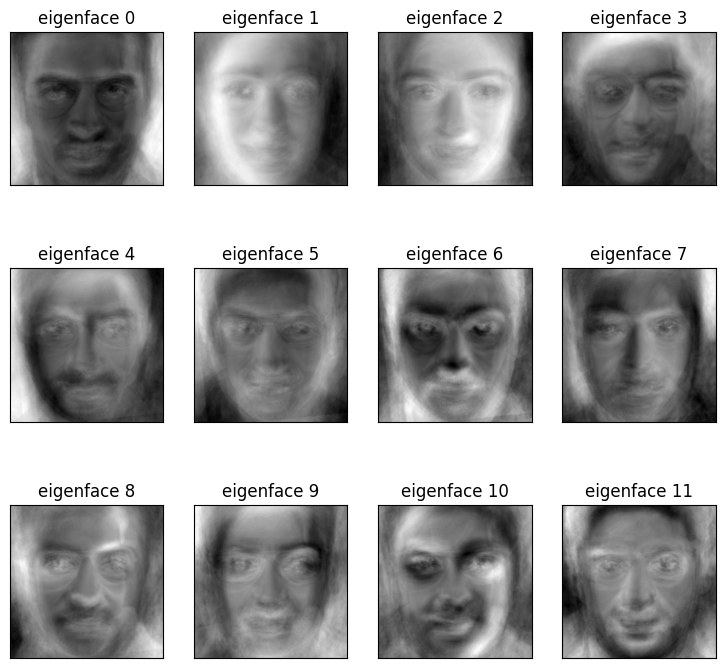

In [46]:
# Visualize the eigenfaces
# Ensure eigenfaces, h, and w are available from previous steps
if 'eigenfaces' in locals() and 'h' in locals() and 'w' in locals():
    print("Visualizing eigenfaces...")
    eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
    plot_gallery(eigenfaces, eigenface_titles, h, w)
else:
    print("Eigenfaces or image dimensions (h, w) not available. Please run the dimensionality reduction cell first.")

## Visualize Prediction Results


Visualizing prediction results on test set...


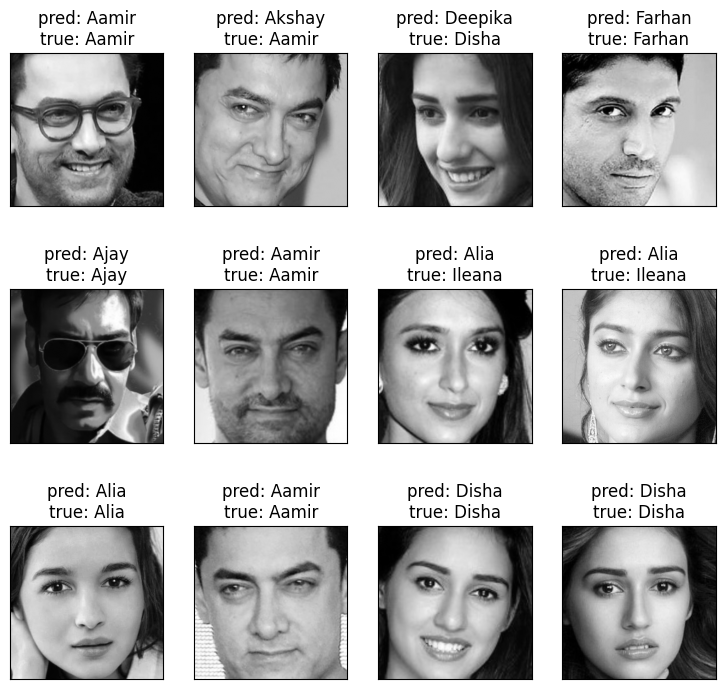

In [48]:
# Visualize some prediction results
# Ensure X_test, y_test, y_pred, target_names, h, and w are available from previous steps
if 'X_test' in locals() and 'y_test' in locals() and 'y_pred' in locals() and 'target_names' in locals() and 'h' in locals() and 'w' in locals() and 'class_names' in locals(): # Added check for class_names
    print("\nVisualizing prediction results on test set...")
    # Select a few random samples from the test set
    n_visualize = 12 # Number of samples to visualize
    sample_indices = np.random.choice(len(X_test), n_visualize, replace=False)

    sample_images = X_test[sample_indices]
    # Use class_names for correct mapping from index to name
    sample_true_names = [class_names[y_test[j]] for j in sample_indices]
    sample_pred_names = [class_names[y_pred[j]] for j in sample_indices]

    prediction_titles = [f"pred: {pred}\ntrue: {true}" for pred, true in zip(sample_pred_names, sample_true_names)]

    plot_gallery(sample_images, prediction_titles, h, w)

else:
    print("Test data (X_test, y_test), predictions (y_pred), target names, class names, or image dimensions (h, w) not available. Please run the previous cells first.") # Updated message